# Problem 1
![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


First Challenge in Task 1 was to generate data as per requirements.

### Data Generation

Data needed to be generated to such an extent that all types of cases are present in it. Like riders with trips below 100 and above, riders with very marginal completion rate and higher ones. So to tackle this issue the following codeblock have been executed.

In [ ]:
# %load Order_data_csv_generation.py
import pandas as pd
import numpy
import random
import datetime
from random import randrange
from datetime import datetime
from datetime import timedelta
from datetime import timezone


def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

start_date = datetime.strptime('1/1/2019 12:00 AM', '%m/%d/%Y %I:%M %p')
end_date = datetime.strptime('1/1/2020 12:00 AM', '%m/%d/%Y %I:%M %p')


status_type = {
	#Type: Weight of Occuring
	'COMPLETED': 7,
	'CANCELLED': 3
}

supply_data_normal = random.sample(range(9001,9800),40)
supply_data_outlier = random.sample(range(9801,9999),10)


columns = [ 'order_id', 'time_stamp', 'supply_id', 'status'] 


df = pd.DataFrame(columns = columns)

#For normal weighted case
for i in range(1,4501):
	status_list = [status for status in status_type]
	status_weights = [status_type[status] for status in status_type]
	status = random.choices(status_list, weights = status_weights)[0]
	supply_id = random.choice(supply_data_normal)
	date_time = random_date(start_date, end_date)
	utc_timestamp = date_time.replace(tzinfo=timezone.utc).timestamp()	
	df.loc[i] = [1000+i, utc_timestamp, supply_id, status]


#For inverse weighting to get outlier cases
for i in range(4501,5501):
	status_list = [status for status in status_type]
	status_weights = [10-status_type[status] for status in status_type]
	status = random.choices(status_list, weights = status_weights)[0]
	supply_id = random.choice(supply_data_outlier)
	date_time = random_date(start_date, end_date)
	utc_timestamp = date_time.replace(tzinfo=timezone.utc).timestamp()	
	df.loc[i] = [1000+i, utc_timestamp, supply_id, status]

#CSV Generation
df.to_csv('demo.csv',index=False)

Here, weight have been given to status so that most of the orders are 'Completed' rather than 'Cancelled'. Nevertheless, due to requirements for outlier cases for some orders the weight have been inversed so we can get few riders with heavy cancellation rate.

Thus we get the following distribution with outlier cases:

In [2]:
%%HTML
<div class='tableauPlaceholder' id='viz1607927023545' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Pa&#47;PathaoTest_OrderData&#47;DistributionofGeneratedData&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='PathaoTest_OrderData&#47;DistributionofGeneratedData' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Pa&#47;PathaoTest_OrderData&#47;DistributionofGeneratedData&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1607927023545');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='727px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Execution

To reduce the overhead calculation every time a completion rate is needed to be known, I have added a trigger for the table ride_orders. This trigger function will put data in the supply_details column as per the supply_id and keep track of total total_trips and completion_rate (based on latest 100 data).

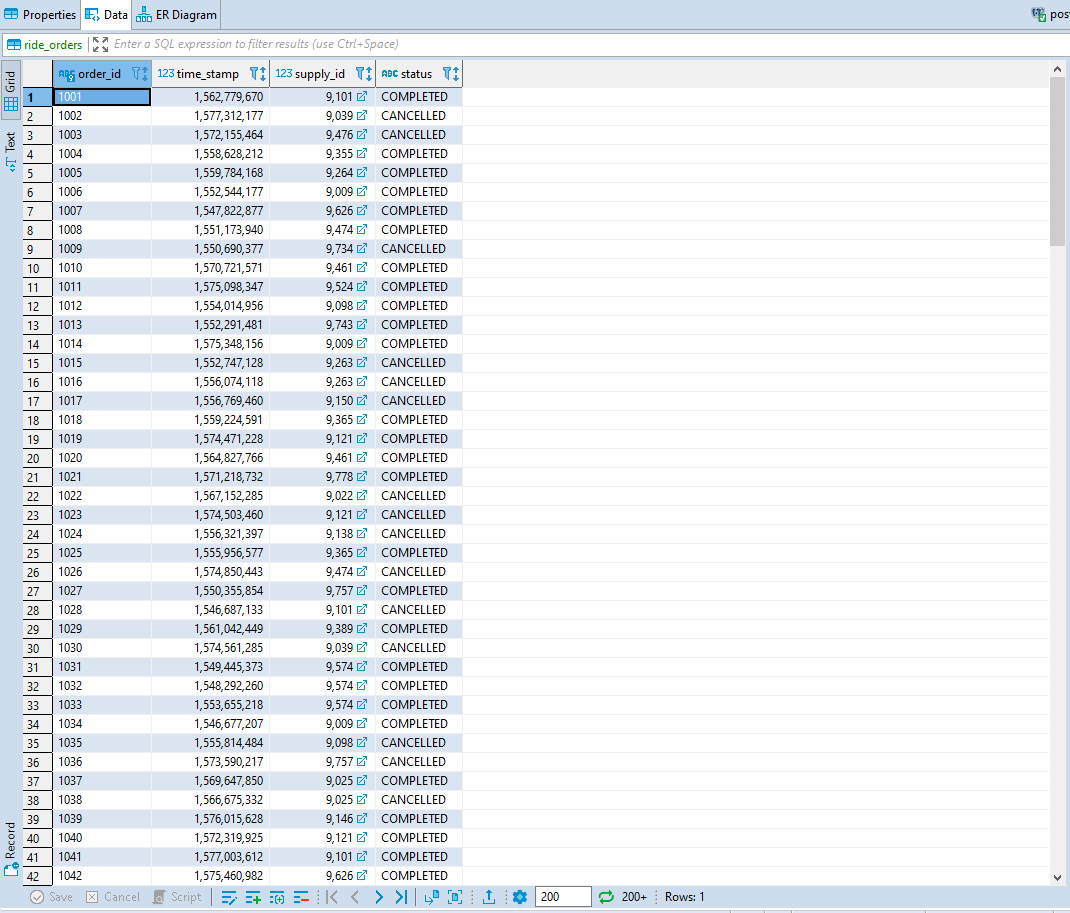

In [3]:
from IPython.display import Image
Image("db_ride_orders.png")

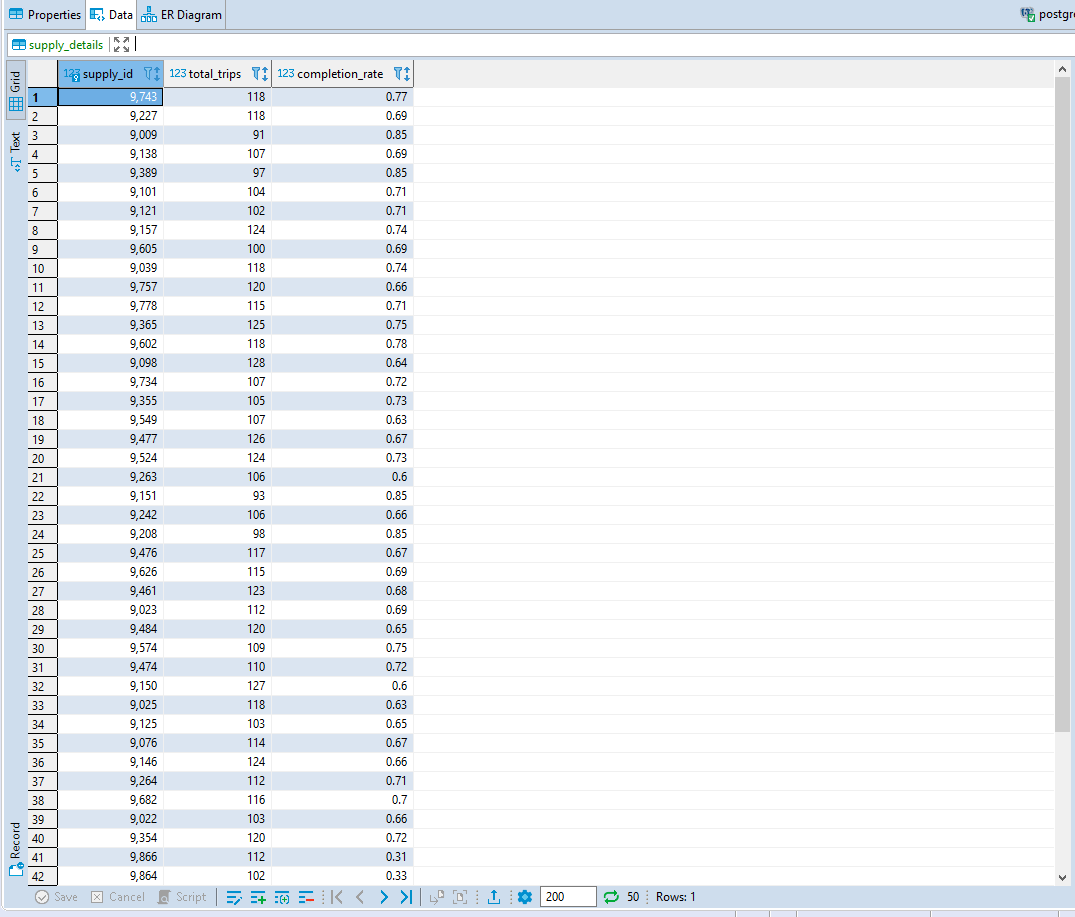

In [4]:
Image("db_supply_details.png")

For this 2 trigger function is used. <br>
1. First one is BeforeInsert(). If the supply_id is not present in the supply_details table then BeforeInsert() creates an entry for that supply_id in table supply_details table.

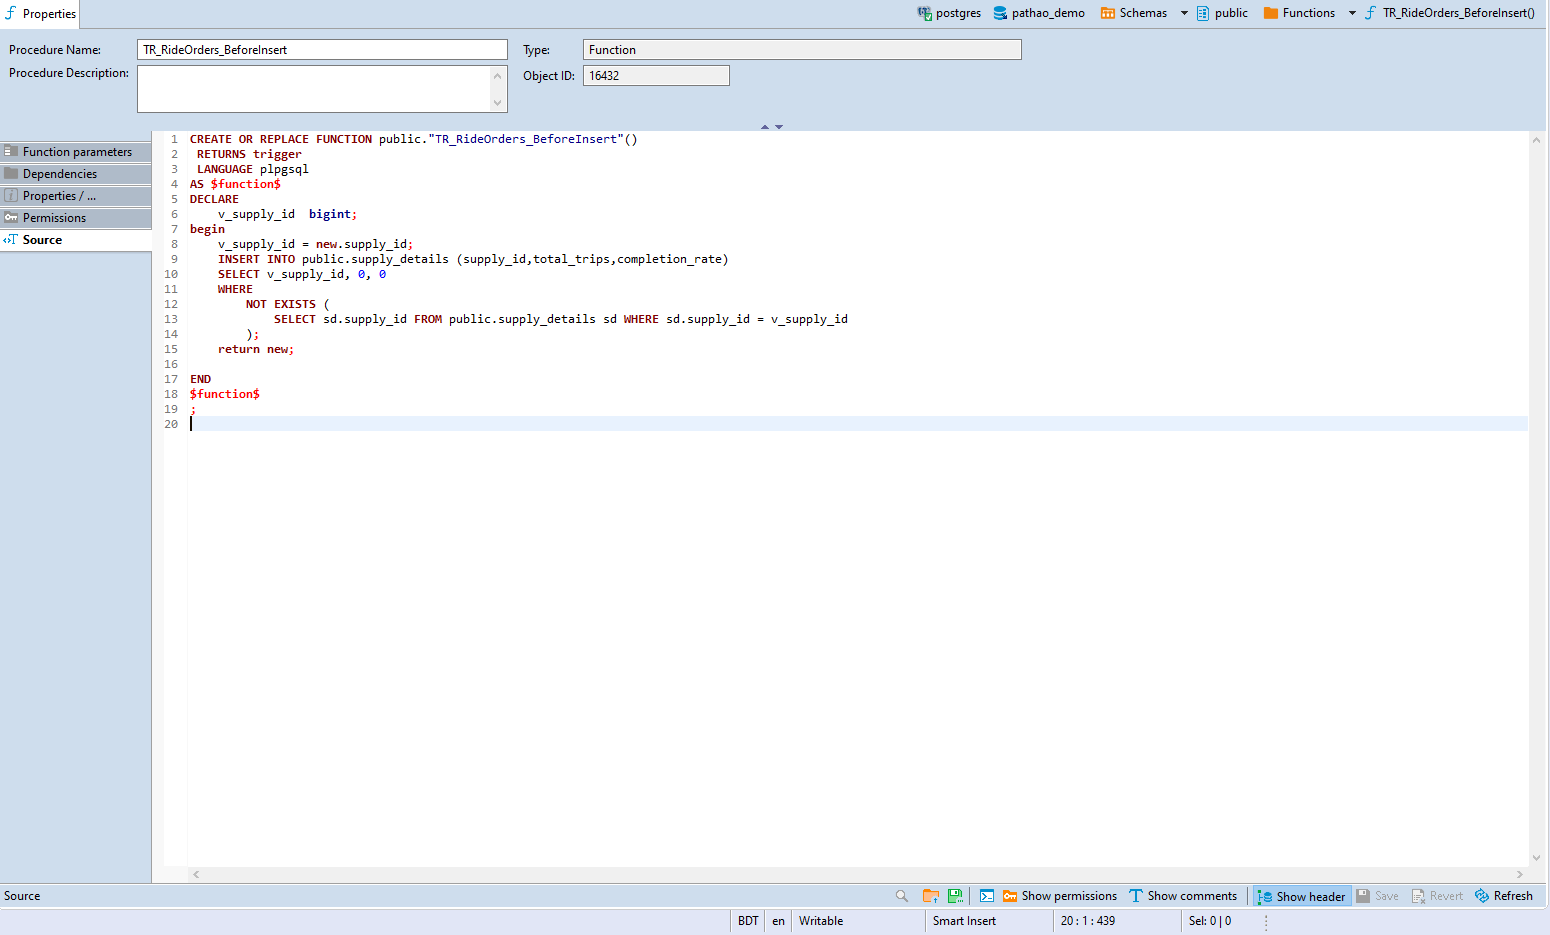

In [5]:
Image("db_ride_orders_BeforeInsert.png")

2. Second one is AfterInsert(). After insertion in ride_orders table it calculates the total_trips & completion_rate column values and insert it into the supply_details table.

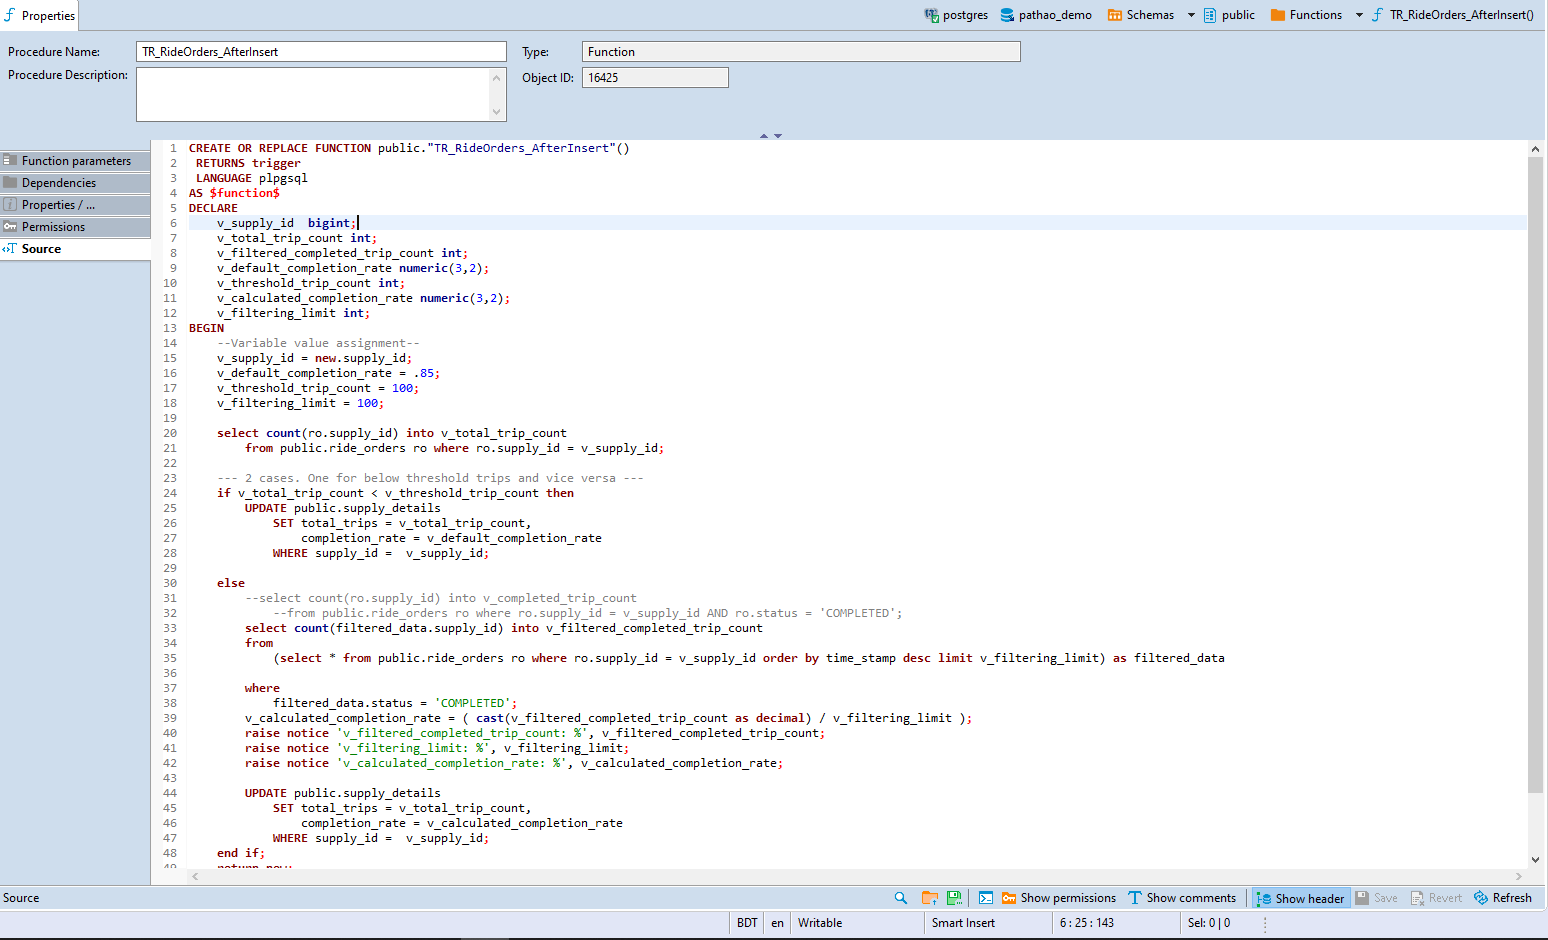

In [6]:
Image("db_ride_orders_AfterInsert.png")

For notifications, notification_messages table has been created with range columns

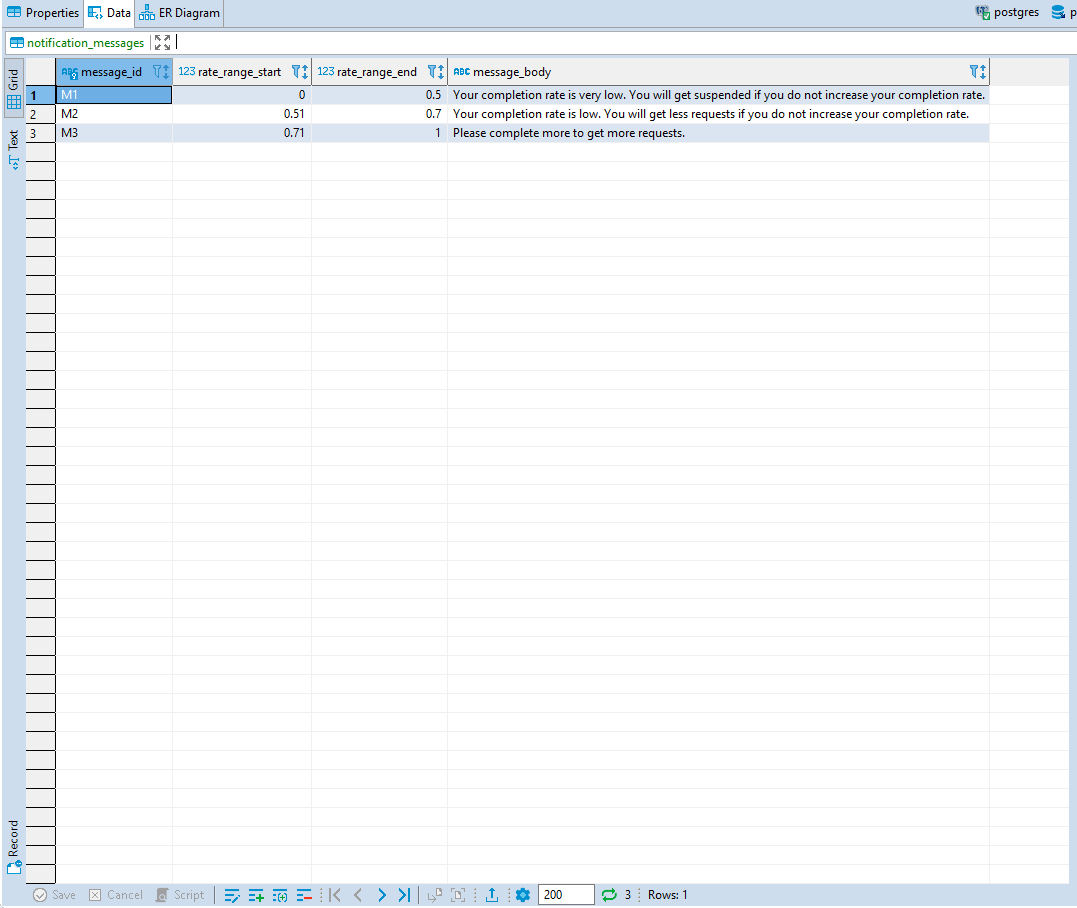

In [7]:
Image("db_notification_messages.png")

To get the completion rate and notification message for the provided supply_id a function has been created which returns the response in JSON format.

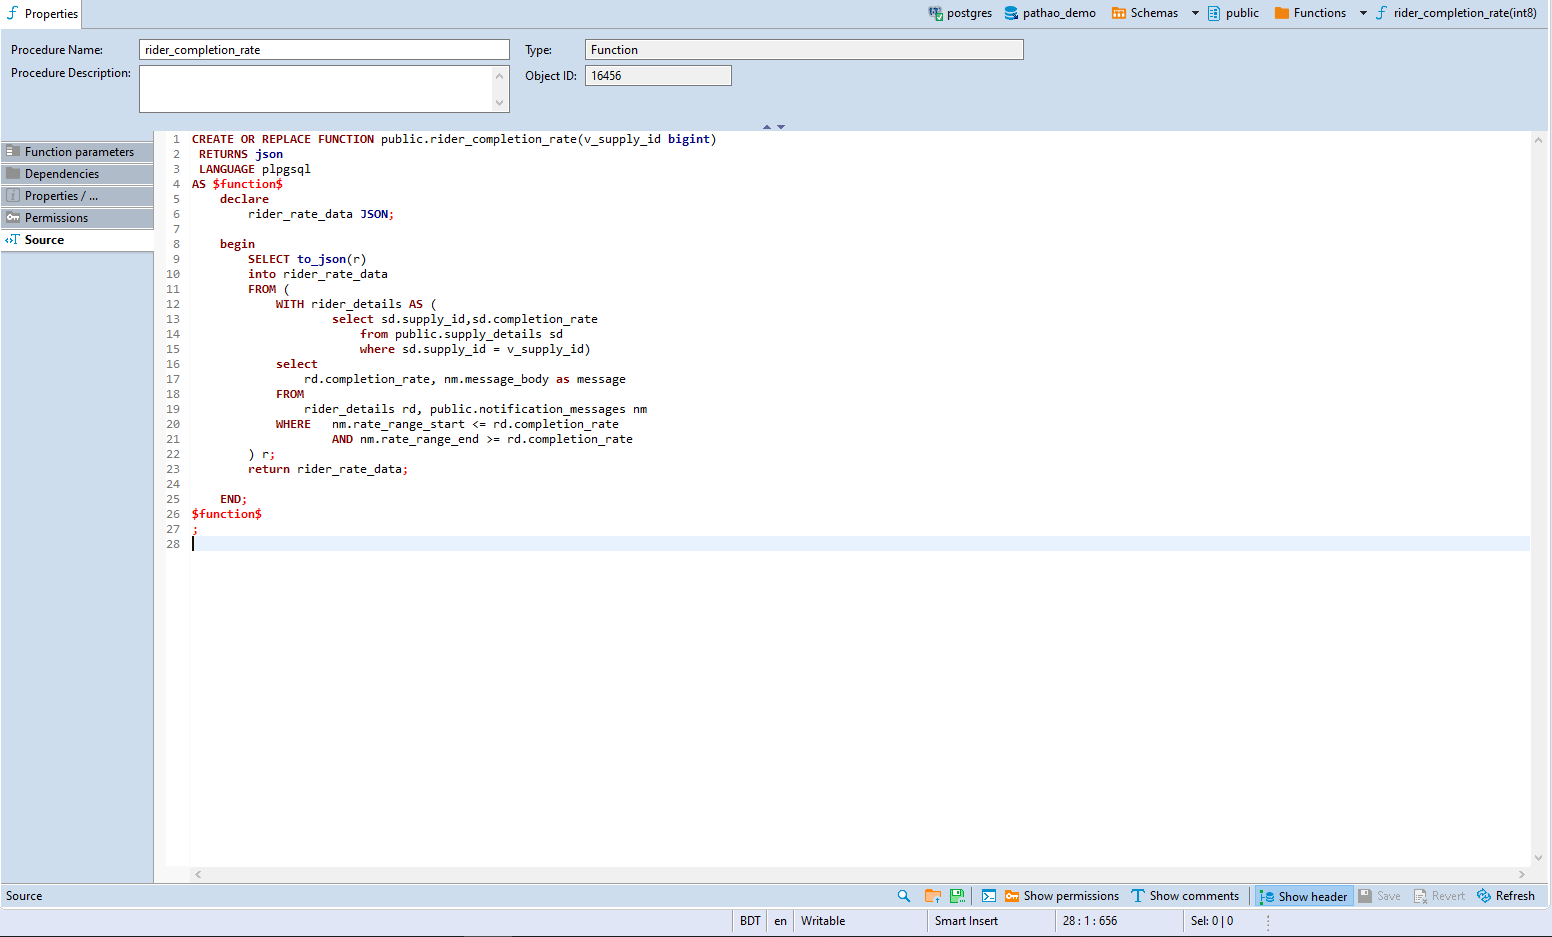

In [8]:
Image("db_rider_completion_rate.png")

Now to access the data from a .py file following python code is created


In [ ]:
# %load Completion_rate_Service.py
import psycopg2
import json


def rider_completion_rate(v_supply_id):  
	connection = psycopg2.connect(
		host = "localhost",
		database = "pathao_demo",
		user= "postgres",
		password = "postgres")

	#cursor
	cur = connection.cursor()

	#execute query
	#SQL = "INSERT INTO authors (name) VALUES (%s);" # Note: no quotes
	query = "Select public.rider_completion_rate( %s )"
	
	str_v_supply_id = str(v_supply_id)
	cur.execute(query,[str_v_supply_id])
	
	row = cur.fetchone()

	if row[0] is not None:
			json_result = json.loads(json.dumps(row[0]))
			print(json_result['completion_rate'])
			print(json_result['message'])
	else:
			print("Not valid Supply ID. Please try again.")

	cur.close()

	#close the connection
	connection.close()
d=1
while d>0:
	v_supply_id = input ("Enter supply_id : ")  
	rider_completion_rate(v_supply_id) 

Thus by entering supply id here in the python execution file we can get completion rate and the notification message